In [1]:
import pandas as pd
import numpy as np

In [2]:
from dataclasses import dataclass
rng = np.random.default_rng()

# Shots Table

In [3]:
df = pd.read_excel("Synthetic Data.xlsx", sheet_name=1)
df.head()

,type,x,y,isgoal,appearance
0,Jump,0,7,False,0
1,Standing,25,25,True,0
2,Dive,18,7,True,0
3,Wing,11,7,True,0
4,Lob,9,1,False,2


In [4]:
def generate_synthetic(df, n_rows, schema):
    synthetic = pd.DataFrame(index=range(n_rows))
    start_time=pd.Timestamp("2026-01-01 00:00")

    for col in schema:
        synthetic[col.name] = rng.integers(
            size=n_rows,
            **col.params
        )
    
    synthetic["velocity"] = rng.lognormal(mean=4.55, sigma=0.16, size=n_rows)
    
    for col in df.select_dtypes(exclude=np.number):
        freq = df[col].value_counts(normalize=True)
        synthetic[col] = rng.choice(
            freq.index,
            size=n_rows,
            p=freq.values
        )

    synthetic["timestamp"] = start_time + pd.to_timedelta(
        rng.uniform(0, 3600, size=n_rows),
        unit="s"
    )
    
    return synthetic

In [5]:
@dataclass
class ColumnDescription:
    name: str
    params: dict

schema = [
    ColumnDescription("appearance", {"low": 0, "high": 25}),
    ColumnDescription("x", {"low": 0, "high": 27}),
    ColumnDescription("y", {"low": 0, "high": 27}),
    ColumnDescription("shooter", {"low": 0, "high": 40}),
]

In [6]:
synth = generate_synthetic(df, n_rows=500, schema=schema)
synth["time"] = synth["timestamp"].dt.time
synth["velocity"] = np.floor(synth["velocity"])
synth = synth.sort_values(by=["appearance", "time"]).reset_index(drop=True)
synth.head(20)

,appearance,x,y,shooter,velocity,type,isgoal,timestamp,time
0,0,1,12,23,109.0,Jump,True,2026-01-01 00:02:23.611800172,00:02:23.611800
1,0,21,13,31,90.0,Bounce,True,2026-01-01 00:04:51.846375275,00:04:51.846375
2,0,23,13,38,76.0,Standing,False,2026-01-01 00:08:25.190742406,00:08:25.190742
3,0,17,22,31,84.0,Hip,False,2026-01-01 00:09:14.282388265,00:09:14.282388
4,0,23,3,12,73.0,Wing,True,2026-01-01 00:12:24.349572902,00:12:24.349572
5,0,12,7,33,87.0,Standing,True,2026-01-01 00:12:34.953007553,00:12:34.953007
6,0,10,23,34,78.0,Lob,True,2026-01-01 00:15:52.125842591,00:15:52.125842
7,0,4,20,28,86.0,Jump,True,2026-01-01 00:16:38.120957002,00:16:38.120957
8,0,22,13,33,74.0,Standing,True,2026-01-01 00:17:25.582696512,00:17:25.582696
9,0,10,14,30,123.0,Dive,True,2026-01-01 00:20:03.901713522,00:20:03.901713


<Axes: >

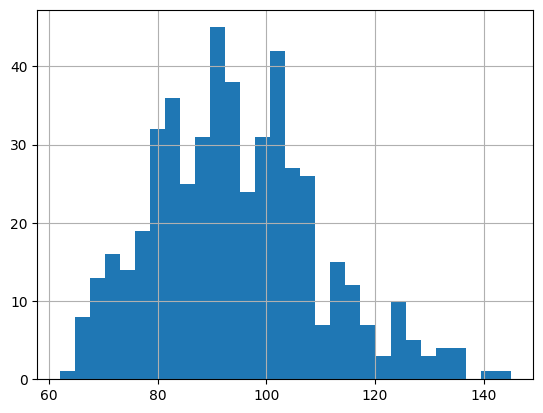

In [7]:
synth["velocity"].hist(bins=30)

# Shooters Table

In [8]:
shooters_df = synth.groupby("shooter")["isgoal"].sum().reset_index(name="total_goals")

# Appearances Table

In [9]:
app_df = (
    synth
    .groupby("appearance")["isgoal"]
    .value_counts()
    .unstack(fill_value=0)
    .reset_index()
)
app_df = app_df.rename(
    columns={True: "conceded", False: "saved"}
).rename_axis(None, axis=1)
app_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25 entries, 0 to 24
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   appearance  25 non-null     int64
 1   saved       25 non-null     int64
 2   conceded    25 non-null     int64
dtypes: int64(3)
memory usage: 732.0 bytes


In [10]:
n_players = 4

player_ids = np.arange(0, n_players)
player_probs = np.array([0.5, 0.25, 0.15, 0.1], dtype=float)
player_probs = player_probs / player_probs.sum()
app_df["player_id"] = rng.choice(player_ids, size=len(app_df), p=player_probs)

app_df["match_id"] = rng.integers(0, 23, size=len(app_df))

# Players Table

In [11]:
player_df = app_df.groupby("player_id")[["saved", "conceded"]].sum().reset_index()
player_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4 entries, 0 to 3
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype
---  ------     --------------  -----
 0   player_id  4 non-null      int64
 1   saved      4 non-null      int64
 2   conceded   4 non-null      int64
dtypes: int64(3)
memory usage: 228.0 bytes


# Matches Table

In [ ]:
match_df = app_df.groupby("match_id")["conceded"].sum().reset_index(name="conceded")

opponents = ["Fábrica de Azulejos Coentrão", "Comunidade Judaica de Vila Real", "Sporting Clube de Cascos de Rolha", "Associação Desportiva de Cascos de Rolha"]
match_df["opponent"] = rng.choice(opponents, size=len(match_df))
match_df["scored"] = rng.integers(5, 26, size=len(match_df))
match_df.head(10)

,match_id,conceded,opponent,goals_scored
0,0,11,Sporting Clube de Cascos de Rolha,11
1,3,9,Fábrica de Azulejos Coentrão,8
2,4,35,Sporting Clube de Cascos de Rolha,19
3,7,11,Sporting Clube de Cascos de Rolha,21
4,8,2,Fábrica de Azulejos Coentrão,7
5,11,12,Fábrica de Azulejos Coentrão,22
6,13,5,Sporting Clube de Cascos de Rolha,13
7,14,18,Comunidade Judaica de Vila Real,21
8,15,6,Sporting Clube de Cascos de Rolha,19
9,16,25,Associação Desportiva de Cascos de Rolha,13


In [18]:
with pd.ExcelWriter("output.xlsx") as writer:
    synth.to_excel(writer, sheet_name="Shots", index=False)
    app_df.to_excel(writer, sheet_name="Appearances", index=False)
    player_df.to_excel(writer, sheet_name="Players", index=False)
    match_df.to_excel(writer, sheet_name="Matches", index=False)
    shooters_df.to_excel(writer, sheet_name="Shooters", index=False)